<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
<b>Привет, Паша!</b>

Меня зовут Алексей Косенко, и я буду проверять твой проект.
    
Предлагаю общаться на «<b>ты</b>», но если это неудобно — обязательно сообщи об этом.
    
Ниже ты увидишь мои комментарии, выделенные разным цветом:
    
<div class="alert alert-success">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>

<b>Отлично!</b> ✔️: все ок, продолжай в том же духе :)

</div>
<div class="alert alert-warning">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
<b>Есть совет</b> ⚠️: так выделены некритичные замечания или советы, которые смогут улучшить твой проект.

</div>
<div class="alert alert-danger">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>

<b>Нужно доработать</b> ❌: так выделены важные замечания — без их исправления проект не может быть принят.
    
</div>

Будет здорово, если ты будешь участвовать в диалоге, а свои вопросы, комментарии и изменения в проекте тоже будешь выделять, например, вот так:
    
<div class="alert alert-info">
    <b>Комментарий студента:</b> твой комментарий
</div>
    
Пожалуйста, не перемещай и не удаляй мои комментарии, это усложнит повторную проверку.
    
</div>

<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
<b>Еще раз привет!</b>

Спасибо, что доделал работу, оформление комментариев остается тем же, только обозначим номер итерации: v2
    
</div>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Просмотр" data-toc-modified-id="Просмотр-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Просмотр</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследование задачи</a></span><ul class="toc-item"><li><span><a href="#Подбор-модели-без-столбца-Tenure" data-toc-modified-id="Подбор-модели-без-столбца-Tenure-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подбор модели без столбца Tenure</a></span></li><li><span><a href="#Борьба-с-дисбалансом-1" data-toc-modified-id="Борьба-с-дисбалансом-1-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Борьба с дисбалансом 1</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Тестирование-модели-1" data-toc-modified-id="Тестирование-модели-1-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Тестирование модели 1</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Подбор-модели-2" data-toc-modified-id="Подбор-модели-2-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Подбор модели 2</a></span></li><li><span><a href="#Борьба-с-дисбалансом-2" data-toc-modified-id="Борьба-с-дисбалансом-2-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Борьба с дисбалансом 2</a></span></li><li><span><a href="#Тестирование-модели-2" data-toc-modified-id="Тестирование-модели-2-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Тестирование модели 2</a></span></li></ul></li><li><span><a href="#ВЫВОД" data-toc-modified-id="ВЫВОД-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>ВЫВОД</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

цель исследования: спрогнозировать, уйдёт клиент из банка в ближайшее время или нет на основе исторических данных о поведении клиентов и расторжении договоров с банком, построить модель с предельно большим значением *F1*-меры.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

### Просмотр

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


In [3]:
try:
    df = pd.read_csv("C:\\Users\\Pasha\\Downloads\\Churn.csv")
except:
    df = pd.read_csv("/datasets/Churn.csv")

df.info()
display(df.head())
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


0

<div class="alert alert-success">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: хорошо, что используешь try-except для загрузки данных</div>

### Вывод

Мы имеем таблицу из 13 столбцов и 10000 строк. названия в верблюжем регистре. Приведем к змеиному.  
3 первых признака не имеют предсказательного смысла. удалим столбцы.  
Так же имеются 2 строковые переменные. Закодируем их при помощи метода One Hot Encoding.  
Явных дубликатов нет.  
В одном из столбцов присутствуют пропуски. попробуем их обработать на следующем этапе.  


<div class="alert alert-success">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: данные на месте :)</div>

## Предобработка

In [4]:
# Приводим названия столбцов к змеиному регистру
columns = []
for name in df.columns:
    new_name = ""
    for i in name:
        if i.isupper():
            new_name += "_" + i.lower()
        else:
            new_name += i
    new_name = new_name[1:]    
    columns.append(new_name)    

df.columns = columns
df.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<div class="alert alert-success">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: можно переименовывать и так, а можно попробовать использовать <a href="https://habr.com/ru/post/349860/" target="blank_">регулярные выражения</a>, они часто упрощают работу, тогда код для перименования из CamelCase в snake_case будет выглядеть примерно так:

    import re
    data = data.rename(columns=lambda column: re.sub(r'(?<!^)(?=[A-Z])', '_', column).lower())</div>

<div class="alert alert-info">
    <b>Комментарий студента:</b>  
    
смотрю на строку выше, как на китайскую грамоту.) Поковыряюсь на досуге. Думаю, регулярные выражения - хорошая штука, но, к сожалению пока моему сознанию недоступная
</div>
   

<div class="alert alert-success">
<h2>Комментарий ревьюера v2<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: по секрету скажу, что подавляющее большинство не умеет писать регулярные выражения сходу, это нормально :) Но используются они при этом повсеместно. Тут часто помогают <a href="https://regex101.com/">онлайн-редакторы</a> регулярных выражений</div>

In [5]:
# проверяем дубликаты среди идентификаторов
display(df["customer_id"].duplicated().sum())

0

все значения в столбце с идентификатором клиента уникальны, значит дубликатов нет

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


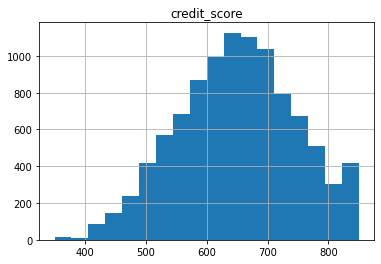

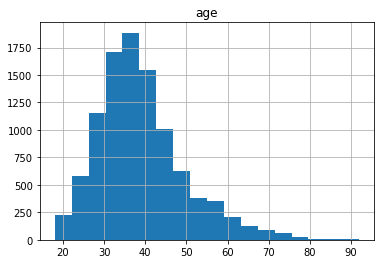

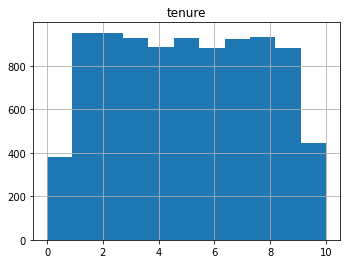

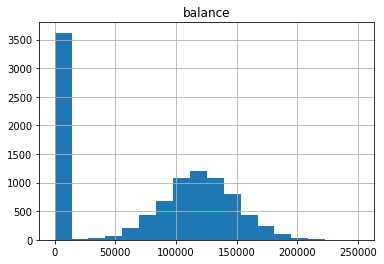

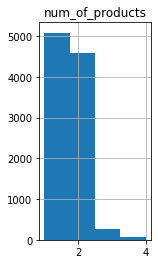

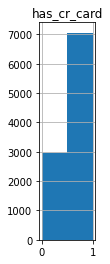

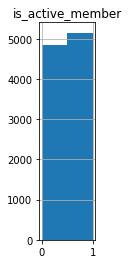

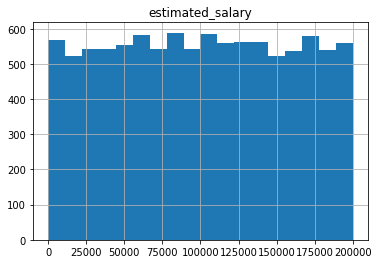

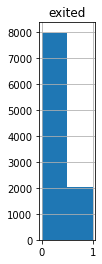

In [6]:
# удаляем бессмысленные признаки
df = df.drop(["row_number", "customer_id", "surname"], axis=1)
# смотрим на распределение значений численых признаков
display(df.describe())
columns = ["credit_score", "age", "tenure", "balance", "num_of_products", "has_cr_card", "is_active_member", "estimated_salary", "exited"]
for column in columns:
    x = len(df[column].value_counts()) 
    if x <= 20:
        plt.figure(figsize=(x/2, 4))
        df[column].hist(bins=x)
    else:
        plt.figure()
        df[column].hist(bins=18)
    plt.title(column)
    plt.show()

 кредитный рейтинг распределен нормально. на максимальных значениях присутствует всплеск. о чем нам это говорит - не понятно, но не похоже на аномалию. Распределение по возрасту имеет форму стремящуюся к нормальному при небольшой скошенности вправо. в районе максимальных значений 80-90 лет присутствуют редкие значения по понятным причинам. Данные выглядят достоверно. в распределении баланса счета есть пик на нуле. выглядит это достаточно странно, потому что нули всречаются как у ушедших клиентов так и у действующих, та же картина с положительным балансом. Боюсь у нас недостаточно данных, чтобы понять как это работает, баланс выглядит неправдоподобно, но распределение нормальное, а значит смысл в данных присутствует, что бы они ни значили.
 Количество лет пользования услугами так же равномерно распределено, не считая провалов на минимальном и максимальном значениях 0, 10лет. в целом данные выглядят правдоподобно, без серьезных аномалий.

In [7]:
# смотрим как распределились строковые значения
display(df["gender"].value_counts())
df["geography"].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

In [8]:
# доля пропусков
display(df["tenure"].isna().mean())
df[df["tenure"].isna()].head(20)

0.0909

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


9 процентов. 

### Вывод

По итогам предобработки закономерностей в данных с пропусками не выявлено. Рассматриваемый признак имеет достаточно случайную природу, и связать его с другими признаками для корректного заполнения данных  не представляется возможным. Других серьезных проблем в данных не обнаружено

<div class="alert alert-success">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: классный исследовательский анализ! Хорошо, что заметил неинформативные признаки</div>

## Исследование задачи

Мы имеем задачу бинарной классификации.  
Целевой признак - Exited.  
Рассмотрим столбец с пропусками более пристально (количество лет пользования услугами банка).  
Посмотрим присутствует ли корреляция между этим признаком и целевым.  
Для полноты картины взглянем и на корреляцию с прочими численными признаками 

In [9]:

# print("tenure")
# display(df["exited"].corr(df["tenure"]))
# print("credit_score")
# display(df["exited"].corr(df["credit_score"]))
# print("estimated_salary")
# display(df["exited"].corr(df["estimated_salary"]))
# print("age")
# display(df["exited"].corr(df["age"]))
# print("balance")
# display(df["exited"].corr(df["balance"]))
# print("num_of_products")
# display(df["exited"].corr(df["num_of_products"]))
# print("has_cr_card")
# display(df["exited"].corr(df["has_cr_card"]))
# print("is_active_member")
# display(df["exited"].corr(df["is_active_member"]))
df.corr()["exited"]

credit_score       -0.027094
age                 0.285323
tenure             -0.016761
balance             0.118533
num_of_products    -0.047820
has_cr_card        -0.007138
is_active_member   -0.156128
estimated_salary    0.012097
exited              1.000000
Name: exited, dtype: float64

<div class="alert alert-info">
    <b>Комментарий студента:</b>
    
Просто шик!
</div>

<div class="alert alert-warning">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Есть совет** ⚠️: чтобы посмотреть на корреляцию признаков с целевым, не обязательно ее считать для каждого признака отдельно, можно построить таблицу корреляции и взять только целевой признак:

    df.corr()['Exited']
</div>

<div class="alert alert-info">
    <b>Комментарий студента:</b>  
    
Ну круто, одним словом! Спасибо! Не знал про такое.
</div>

<div class="alert alert-success">
<h2>Комментарий ревьюера v2<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: 👍</div>

все признаки очень слабо коррелируют с целевым. Одно из наиболее низких значений корреляции у признака, по которому отсутствует часть данных.

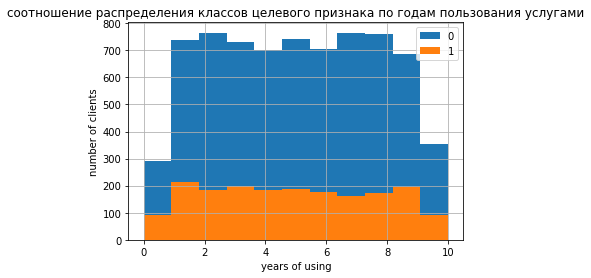

In [9]:
df.groupby("exited")["tenure"].hist(bins=11)
plt.title("соотношение распределения классов целевого признака по годам пользования услугами")
plt.xlabel("years of using")
plt.ylabel("number of clients")
plt.legend("01")
plt.show()

In [10]:
# посмотрим на цифры

p = df.pivot_table(index="tenure", values="exited", aggfunc= ["sum", "mean"])
p.columns = ["кол-во ушедших", "доля ушедших"]
p

,кол-во ушедших,доля ушедших
tenure,,
0.0,90,0.235602
1.0,213,0.223739
2.0,185,0.194737
3.0,198,0.213362
4.0,184,0.207910
5.0,187,0.201726
6.0,177,0.200908
7.0,160,0.172973
8.0,174,0.186495


соотношение распределилось достаточно равномерно доля ушедших среди групп находится в диапазоне от 17 до 23%. Закономерно сделать предположение, что данный признак может не иметь большого значения для модели. соответственно исходя из данной гипотизы, найдем лучшие модели для 2 выборок:
1. без строк с пропусками
2. без столбца с пропусками

Посмотрим на баланс классов

In [11]:
display(df["exited"].value_counts())
print("доля ушедших:")
df["exited"].mean()

0    7963
1    2037
Name: exited, dtype: int64

доля ушедших:


0.2037

Наблюдается дисбаланс классов целевого признака.

<div class="alert alert-success">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: все так, жуткий дисбаланс</div>

<div class="alert alert-warning">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Есть совет** ⚠️: для наглядности стоит добавить график: круговую или столбчатую диаграмму</div>

<div class="alert alert-info">
    <b>Комментарий студента:</b>  
    
ОК
</div>

<div class="alert alert-success">
<h2>Комментарий ревьюера v2<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: 👍</div>

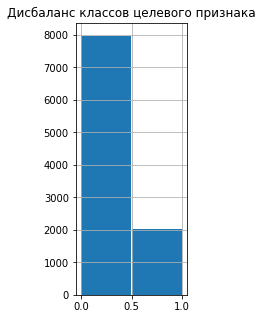

In [25]:
plt.figure(figsize=(2, 5))
df["exited"].hist(bins=2, width=0.499)
plt.title("Дисбаланс классов целевого признака")
plt.show()

Закодируем строковые категориальные признаки

In [12]:
# прямое кодирование
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.columns = df_ohe.columns.str.lower()
df_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


<div class="alert alert-success">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: хорошо, что используешь OHE для кодирования в этом случае</div>

<div class="alert alert-warning">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Есть совет** ⚠️: нужно масштабировать данные перед дальнейшей работой с моделями, чтобы модели воспринимали все признаки одинаково важными, либо пояснить, почему масштабирование не нужно</div>

<div class="alert alert-info">
    <b>Комментарий студента:</b>  
    
Спасибо! Пробежался по теории. всё вспомнил. Standard Scaler. Учту. Закреплю. Сейчас менять не буду, чтобы не лопатить снова результаты, которые изменятся
</div>

### Подбор модели без столбца Tenure

In [13]:
# выделяем целевой признак
features = df_ohe.drop(["exited", "tenure"], axis=1)
target = df_ohe["exited"]
# разбиваем выборку на 3 части, применяя стратификацию
X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.4, random_state=12345, stratify=target)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=12345, stratify=y_valid)
print("ok")


ok


<div class="alert alert-success">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: с размерами выборок все окей :) Здорово, что знаешь про stratify!</div>

In [14]:
# логистическая регрессия
model = LogisticRegression(random_state=12345, solver="liblinear")
# обучение
model.fit(X_train, y_train)
predictions = model.predict(X_valid)
print(f1_score(y_valid, predictions))

0.06263982102908278


Слишком низкий показатель F1-меры. Очевидно, алгоритм логистической регрессии не подходит для нашей задачи. оптимизировать модель не вижу смысла.

In [15]:
def tree_opt(depth_min, depth_max, weight):
    """функция перебирает значения глубины дерева решений и 
    возвращает модель с наибольшим значением f1,   
    вывдя на дисплей данные по ней"""
    best_model = None
    best_depth = 0
    best_f1 = 0
    for depth in range (depth_min, depth_max):
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight=weight)
        model.fit(X_train, y_train)
        predictions = model.predict(X_valid)
        f1 = f1_score(y_valid, predictions)
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_depth = depth
    print(f"f1 = {best_f1}, глубина = {best_depth}")
    probabilities = best_model.predict_proba(X_valid)
    probabilities_one = probabilities[:, 1]
    print("auc roc =", roc_auc_score(y_valid, probabilities_one))
    return best_model
best_tree = tree_opt(1, 20, None)


f1 = 0.5939741750358679, глубина = 7
auc roc = 0.8268186828751601


<div class="alert alert-success">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: молодец, что выносишь подбор параметров в функции</div>

<div class="alert alert-warning">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Есть совет** ⚠️: для наглядности стоит добавить график AUC-ROC в сравнении со случайной моделью(AUC-ROC=0.5)</div>

<div class="alert alert-info">
    <b>Комментарий студента:</b>  
    
Думаю, это можно назвать делом вкуса. Мне кажется, наглядность сравнения рок-кривой с X=Y сильно преувеличена) Не знаю, какой эффект это производит на других, но меня не впечатлило
</div>

<div class="alert alert-warning">
<h2>Комментарий ревьюера v2<a class="tocSkip"></a></h2>
    
**Есть совет** ⚠️: вот тут не соглашусь, AUC-ROC — это, пожалуй, самый полезный график при решении задачи бинарной классификации. Во-первых, просто по виду графика можно определить, как распределены целевой признак и предсказания, тут есть хорошая <a href="https://ml-handbook.ru/chapters/model_evaluation/intro#auc">статья</a> с примером на эту тему. Во-вторых — по этому графику можно определить лучшее значение порога классификации без перебора, подробнее про это можно почитать <a href="https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/" target="blank_">здесь</a>.  Ну и в третьих, значение AUC-ROC, которое ты рассчитываешь имеет очень точный геометрический смысл — а именно, площадь под ROC-кривой, без графика этот смысл теряется. А само сравнение с y=x — это удобная проверка на адекватность нашей модели</div>

Лучший результат получен при глубине равной 7, но значение f1 недостаточно высоко. посмотрим, как модель отреагирует на балансировку классов целевого признака

In [16]:
best_tree_balanced = tree_opt(1, 20, "balanced")

f1 = 0.5753931544865865, глубина = 6
auc roc = 0.8235925337471672


значение f1 увеличилось незначительно, как и auc-roc

In [17]:
# лес
def forest_opt(est_min, est_max, step, depth_min, depth_max, weight):
    """функция  получает на вход минимальные и максимальные значения количества 
    и глубины деревьев случайного леса, и возвращает модель с наибольшим значением f1,
    и выводит на дисплей данные по ней"""
    best_f1 = 0
    best_model = None
    best_est = 0
    best_depth = 0
    for est in range(est_min, est_max, step):
        for depth in range(depth_min, depth_max):
            model = RandomForestClassifier(random_state=12345,max_depth=depth, n_estimators=est, class_weight=weight)
            model.fit(X_train, y_train)
            predictions = model.predict(X_valid)
            f1 = f1_score(y_valid, predictions)
            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                best_est = est
                best_depth = depth
            
    print(f"f1 {best_f1}, кол-во деревьев {best_est}, глубина {best_depth}")
    probabilities = best_model.predict_proba(X_valid)
    probabilities_one = probabilities[:, 1]
    print("auc roc =", roc_auc_score(y_valid, probabilities_one))
    return best_model
best_forest = forest_opt(1, 101, 10, 1, 20, None)


f1 0.6244477172312224, кол-во деревьев 61, глубина 13
auc roc = 0.8610638979209775


Значение f1 преодолело критическую отметку. попытаемся улучшить модель. сузим диапазон и уменьшим шаг для количества деревьев

In [18]:
best_forest = forest_opt(52, 70, 1, 11, 15, None)


f1 0.629575402635432, кол-во деревьев 65, глубина 13
auc roc = 0.8612286308995961


Вновь незначительный рост

### Борьба с дисбалансом 1

сбалансируем классы

In [19]:
best_forest_balanced = forest_opt(1, 101, 10, 1, 20, "balanced")


f1 0.6524663677130045, кол-во деревьев 81, глубина 8
auc roc = 0.8719709146221303


In [20]:
# уменьшаем диапазон кол-ва деревьев
best_forest_balanced = forest_opt(52, 70, 1, 6, 10, "balanced")

f1 0.6525139664804469, кол-во деревьев 63, глубина 8
auc roc = 0.8713212200709429


Мы получили достаточно высокое значение основной метрики. значение площади под рок-кривой во всех случаях растет вместе со значением f1  
Подберем порог для несбалансированной модели

In [21]:

def best_forest_threshold(forest):
    """функция принимает на вход обученную модель и возвращает значения 
    метрик качества при разных порогах, а так же лучшие показатели f1"""
    probabilities = forest.predict_proba(X_valid)
    probabilities_one = probabilities[:, 1]
    best_f1 = 0
    best_threshold = 0
    for threshold in np.arange(0, 1, 0.02):
        predictions = probabilities_one > threshold
        precision = precision_score(y_valid, predictions)
        recall = recall_score(y_valid, predictions)
        f1 = f1_score(y_valid, predictions)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
        print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.5f}".format(threshold, precision, recall, f1))
    print("лучший порог:", best_threshold, "лучшее значение f1:", best_f1)
    
best_forest_threshold(best_forest)

Порог = 0.00 | Точность = 0.204, Полнота = 1.000, f1 = 0.33887
Порог = 0.02 | Точность = 0.232, Полнота = 0.985, f1 = 0.37570
Порог = 0.04 | Точность = 0.258, Полнота = 0.956, f1 = 0.40625
Порог = 0.06 | Точность = 0.287, Полнота = 0.939, f1 = 0.43922
Порог = 0.08 | Точность = 0.317, Полнота = 0.914, f1 = 0.47066
Порог = 0.10 | Точность = 0.347, Полнота = 0.897, f1 = 0.50000
Порог = 0.12 | Точность = 0.381, Полнота = 0.875, f1 = 0.53086
Порог = 0.14 | Точность = 0.409, Полнота = 0.850, f1 = 0.55211
Порог = 0.16 | Точность = 0.432, Полнота = 0.814, f1 = 0.56463
Порог = 0.18 | Точность = 0.461, Полнота = 0.789, f1 = 0.58175
Порог = 0.20 | Точность = 0.482, Полнота = 0.767, f1 = 0.59168
Порог = 0.22 | Точность = 0.503, Полнота = 0.750, f1 = 0.60236
Порог = 0.24 | Точность = 0.534, Полнота = 0.730, f1 = 0.61698
Порог = 0.26 | Точность = 0.560, Полнота = 0.711, f1 = 0.62635
Порог = 0.28 | Точность = 0.573, Полнота = 0.691, f1 = 0.62667
Порог = 0.30 | Точность = 0.600, Полнота = 0.676, f1 = 

### Вывод

Для лучшей модели случайного леса с несбалансированными классами найден порог при котором значение метрики качества достигает достаточно высокого значения, но более сильный эффект мы получили при балансировке классов. 

### Тестирование модели 1

In [22]:
# проверяем лучшую модель на тестовой выборке
predictions = best_forest_balanced.predict(X_test)
print(f1_score(y_test, predictions))

0.6119235095613048


### Вывод

Мы достигли необходимого значения f1-меры. Оно ниже значения на валидации но выше заданного порога.

### Подбор модели 2

Проделаем все те же манипуляции для выборки без строк с пропусками

In [23]:
# кодирование строковых категориальных признаков
df_ohe_drop_rows = df_ohe.dropna()
df_ohe_drop_rows.shape

(9091, 12)

In [24]:
# деление на выборки
features = df_ohe_drop_rows.drop("exited", axis=1)
target = df_ohe_drop_rows["exited"]
X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.4, random_state=12345, stratify=target)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=12345, stratify=y_valid)

print("ok")

ok


In [25]:
# логистическая регрессия
model = LogisticRegression(random_state=12345, solver="liblinear")
model.fit(X_train, y_train).get_params()
predictions = model.predict(X_valid)
print("f1", f1_score(y_valid, predictions))

f1 0.07637231503579953


слишком низкое значение, дальнейшая оптимизация бессмысленна

In [26]:
# дерево решений
best_tree_drop_rows = tree_opt(1, 20, None)

f1 = 0.5815126050420169, глубина = 7
auc roc = 0.8245379882534177


In [27]:
# дерево со сбалансированными классами
best_tree_drop_rows_balanced = tree_opt(1, 20, "balanced")

f1 = 0.583084577114428, глубина = 6
auc roc = 0.8353643657199484


балансировка классов немного увеличивает значения основных метрик качества

In [28]:
# случайный лес
best_forest_drop_rows = forest_opt(1, 101, 10, 1, 20, None)

f1 0.6245954692556633, кол-во деревьев 51, глубина 19
auc roc = 0.8660198533260561


In [29]:
# уменьшаем диапазон и шаг кол-ва деревьев
best_forestdrop_rows = forest_opt(42, 60, 1, 17, 22, None)

f1 0.6245954692556633, кол-во деревьев 51, глубина 19
auc roc = 0.8660198533260561


для второй выборки все значения метрик качества ниже, чем для первой

### Борьба с дисбалансом 2

In [30]:
# балансируем классы
best_forest_drop_rows_balanced = forest_opt(1, 101, 10, 1, 20, "balanced")

f1 0.648030495552732, кол-во деревьев 41, глубина 9
auc roc = 0.872579572570445


In [31]:
# уменьшаем диапазоны и шаг гиперпараметров
best_forest_drop_rows_balanced = forest_opt(62, 80, 1, 7, 11, "balanced")

f1 0.6454891994917409, кол-во деревьев 63, глубина 9
auc roc = 0.8744963555045572


In [32]:
# оптимизация подбором порога
best_forest_threshold(best_forest_drop_rows)

Порог = 0.00 | Точность = 0.220, Полнота = 0.997, f1 = 0.36027
Порог = 0.02 | Точность = 0.251, Полнота = 0.989, f1 = 0.40044
Порог = 0.04 | Точность = 0.274, Полнота = 0.968, f1 = 0.42713
Порог = 0.06 | Точность = 0.298, Полнота = 0.941, f1 = 0.45237
Порог = 0.08 | Точность = 0.321, Полнота = 0.919, f1 = 0.47626
Порог = 0.10 | Точность = 0.342, Полнота = 0.898, f1 = 0.49480
Порог = 0.12 | Точность = 0.368, Полнота = 0.873, f1 = 0.51757
Порог = 0.14 | Точность = 0.389, Полнота = 0.846, f1 = 0.53311
Порог = 0.16 | Точность = 0.412, Полнота = 0.827, f1 = 0.55018
Порог = 0.18 | Точность = 0.442, Полнота = 0.814, f1 = 0.57251
Порог = 0.20 | Точность = 0.466, Полнота = 0.795, f1 = 0.58765
Порог = 0.22 | Точность = 0.490, Полнота = 0.763, f1 = 0.59705
Порог = 0.24 | Точность = 0.512, Полнота = 0.744, f1 = 0.60659
Порог = 0.26 | Точность = 0.537, Полнота = 0.728, f1 = 0.61785
Порог = 0.28 | Точность = 0.569, Полнота = 0.720, f1 = 0.63571
Порог = 0.30 | Точность = 0.594, Полнота = 0.701, f1 = 

значение f1 для случайного леса при сбалансированных классах совсем немного выше, чем значение при оптимальном пороге

### Тестирование модели 2

In [33]:
predictions = best_forest_drop_rows_balanced.predict(X_test)
print(f1_score(y_test, predictions))

0.5970937912813737


<div class="alert alert-success">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: шикарная работа с моделями! Интересный у тебя получился эксперимент, как оказалось, признак `tenure` практически не влияет результат. Но для того, чтобы узнать, как именно тот или иной признак влияет на обучение модели, не обязательно обучать модель на разных выборках, достаточно посмотреть на **feature_importances**, то есть важность признаков для решения модели. Если важность очень мала, то такие признаки можно и удалить, метрики поменяются незначительно. Будет здорово, если получится реализовать

Подробнее про **feature_importances**:
* https://towardsdatascience.com/understanding-feature-importance-and-how-to-implement-it-in-python-ff0287b20285
* https://medium.com/analytics-vidhya/feature-importance-explained-bfc8d874bcf
* https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
* https://christophm.github.io/interpretable-ml-book/feature-importance.html</div>

<div class="alert alert-warning">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Есть совет** ⚠️: не хватает только таблички с результатами, где будет название модели, способ борьбы с дисбалансом, название выборки(с `tenure`/без `tenure`), лучшие гиперпараметры и значения метрик</div>

<div class="alert alert-info">
    <b>Комментарий студента:</b>  
    
Сам так подумал, когда взглянул на свой проект по завершении. Не захотел ковыряться, аппендить все результаты в списки. Может есть какой-то более рациональный способ собрать всё вместе. мне ничего умного в голову не пришло и оставил все как есть. Учитывая, что комментарий желтый, в этот раз поступлю так же.  
    спасибо за проверку и полезные советы! Материала на курсе маловато, а информацию на английском мой мозг переваривает крайне плохо. То, что не понимаешь, не понимаешь еще лучше на языке, которого не понимаешь)) Если есть что полезное почитать на русском, буду признателен.
</div>

<div class="alert alert-success">
<h2>Комментарий ревьюера v2<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: так как у тебя обучение моделей реализовано в функциях, то тебе очень просто заносить результаты в таблицу: ты можешь создать пустой датафрейм перед обучением, а внутри функций добавлять в него полученные значения после подбора гиперпараметров. Получается, нужно добавить только один параметр у функции — название выборки и создать сам датафрейм

А вообще без навыка чтения на английском очень сложно обучаться, это не менее важный навык, чем знание Python(если не более). На русском материалы, конечно, тоже есть, но их заметно меньше и часто это просто переводы англоязычных статей.
    
Конкретно про важность признаков на русском можно почитать, например, здесь:
    
* https://newtechaudit.ru/feature-importance-v-sklearn-i-catboost-na-primere-klassicheskih-datasetov/
* https://www.helenkapatsa.ru/vazhnost-priznaka/
    
А самые полезные материалы по ML на русском обычно можно найти здесь:
* https://ml-handbook.ru/
* https://dyakonov.org/
* https://habr.com/ru/hub/machine_learning/
</div>

## ВЫВОД

Было проведено исследование на предмет на предмет поиска наиболее подходящей модели машинного обучения. В ходе исследования было протестировано 3 различных тип моделей на двух выборках. Наибольшее значение метрики F1, было получено на выборке без признака с неполными данными при помощи модели случайного леса оптимизированной путем подбора гиперпараметров: глубины и количества деревьев, а так же балансировки классов. Подбор порога так же дал неплохие, но меньшие результаты. Метрика AUC-Roc возрастала по мере возрастания F1.  


Upsampling и downsampling не внушают доверия, в связи с чем были проигнорированы.  
Необходимое значение основной метрики качества было достигнуто.

<div style="padding: 20px 25px; border: 2px #6495ed solid">
    
<h2 style="color: #87187D">Итоговый комментарий ревьюера<a class="tocSkip"></a></h2>

Классный проект, спасибо!
    
Шикарная работа с моделями, подробный анализ, вдумчивые выводы, все супер!

Критичных замечаний нет, остальные комментарии можно найти в проекте.

**Я готов принять твой проект в этом виде, если ты просто отправишь его обратно**. Но если есть желание его доработать, с удовольствием посмотрю его еще раз :)
    
Готов ответить на любые вопросы!

<b>Удачи!</b>
        
</div>

<div style="padding: 20px 25px; border: 2px #6495ed solid">
    
<h2 style="color: #87187D">Итоговый комментарий ревьюера v2<a class="tocSkip"></a></h2>

Здорово, что получилось применить некоторые советы :)

Ну а теперь, как и обещал, я могу принять твой проект.

<b>Успехов в обучении!</b>
        
</div>

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*